## 2.2 How to Model Human Activity From Smartphone Data

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2022.4.26 </div>
<div style="text-align: right\"> Last update: 2022.4.26</div>

- 출처 : https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

from scipy.signal import find_peaks

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [3]:
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df

In [4]:
data = load_file('data/UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt')

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.123217,-0.126876,-0.124004,-0.124928,-0.125767,-0.124462,-0.127361,-0.127891,-0.125868,-0.124368,...,-0.123493,-0.121995,-0.123910,-0.127970,-0.128295,-0.127010,-0.126185,-0.124070,-0.122745,-0.121326
1,-0.123976,-0.126808,-0.127786,-0.126655,-0.123634,-0.124919,-0.124300,-0.119798,-0.119222,-0.120174,...,-0.117672,-0.119885,-0.122055,-0.122978,-0.122969,-0.127339,-0.132329,-0.129027,-0.126424,-0.130519
2,-0.120016,-0.121499,-0.122841,-0.123717,-0.123817,-0.121304,-0.121258,-0.125411,-0.129458,-0.129856,...,-0.134438,-0.133090,-0.134369,-0.133016,-0.130937,-0.130473,-0.130305,-0.130876,-0.131210,-0.130183
3,-0.133404,-0.134364,-0.135203,-0.134048,-0.130632,-0.123746,-0.118772,-0.122888,-0.127193,-0.126323,...,-0.127894,-0.127629,-0.129888,-0.130819,-0.128451,-0.126481,-0.127507,-0.131986,-0.134507,-0.133316
4,-0.128731,-0.127846,-0.128230,-0.129854,-0.132752,-0.133991,-0.131159,-0.129970,-0.131889,-0.133298,...,-0.121851,-0.122087,-0.123337,-0.124236,-0.127601,-0.126752,-0.124824,-0.124559,-0.121456,-0.123494


In [6]:
data.shape

(7352, 128)

다음 단계는 파을 그룹을 로드한다.....   

시계열에서는 다음과 같은 구조로 데이터가 되어 있어야 한다.  


[samples, timesteps, features]

In [12]:
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded

In [13]:
filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
total_acc = load_group(filenames, prefix='data/UCI HAR Dataset/train/Inertial Signals/')
print(total_acc.shape)

(7352, 128, 3)


- 세번째 축으로 결합하여 3차원을 만듬

이제 두 함수를 사용하여 학습용, 시험용 데이터셋을 로드하는 함수를 만든다.

In [15]:
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

In [18]:
# load all train
trainX, trainy = load_dataset('train', 'data/UCI HAR Dataset/')
print(trainX.shape, trainy.shape)
# load all test
testX, testy = load_dataset('test', 'data/UCI HAR Dataset/')
print(testX.shape, testy.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


### Balance of Activity Classes

30개 대상이 6개의 동작을 한다고 가정함

In [21]:
trainy.head()

,0
0,5
1,5
2,5
3,5
4,5


In [27]:
trainy.value_counts().sort_index()

1    1226
2    1073
3     986
4    1286
5    1374
6    1407
dtype: int64

In [25]:
trainy.groupby(0).size()

0
1    1226
2    1073
3     986
4    1286
5    1374
6    1407
dtype: int64

In [26]:
trainy.groupby(0).size().values

array([1226, 1073,  986, 1286, 1374, 1407], dtype=int64)

In [30]:
def class_breakdown(data):
	# convert the numpy array into a dataframe
	df = pd.DataFrame(data)
	# group data by the class value and calculate the number of rows
	counts = df.groupby(0).size()
	# retrieve raw rows
	counts = counts.values
	# summarize
	for i in range(len(counts)):
		percent = counts[i] / len(df) * 100
		print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [31]:
trainy = load_file('data/UCI HAR Dataset/train/y_train.txt')
print('Train Dataset')
class_breakdown(trainy)

Train Dataset
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138


In [33]:
testy = load_file('data/UCI HAR Dataset/test/y_test.txt')
print('Test Dataset')
class_breakdown(testy)

Test Dataset
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222


In [36]:
# summarize combined class breakdown
print('Both')
combined = np.vstack((trainy, testy))
class_breakdown(combined)

Both
Class=1, total=1722, percentage=16.720
Class=2, total=1544, percentage=14.992
Class=3, total=1406, percentage=13.652
Class=4, total=1777, percentage=17.254
Class=5, total=1906, percentage=18.507
Class=6, total=1944, percentage=18.876


### Plot Time Series Data for One Subject

원본데이터는 윈도우를 사용해서 50%가 오버랩된다. 
그래서 시계열 차트를 그리면 겹칠 수가 있다.

일단 읽어보자.

In [37]:
X_train, y_train = load_dataset('train', 'data/UCI HAR Dataset/')

In [39]:
X_train.shape

(7352, 128, 9)

각 열의 맵핑이 정의된 subject_train.txt 파일을 읽어오자.

In [40]:
sub_map = load_file('data/UCI HAR Dataset/train/subject_train.txt')

In [41]:
sub_map[:5]

,0
0,1
1,1
2,1
3,1
4,1


In [43]:
train_subjects = np.unique(sub_map)
print(train_subjects)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


In [81]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map.iloc[i].values==sub_id]
	# return the selected samples
	return X[ix, :, :], y.iloc[ix]

In [82]:
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series

In [86]:
# plot the data for one subject
def plot_subject(X, y):
	plt.figure(figsize = (12, 16))
	# determine the total number of plots
	n, off = X.shape[2] + 1, 0
	# plot total acc
	for i in range(3):
		plt.subplot(n, 1, off+1)
		plt.plot(to_series(X[:, :, off]))
		plt.title('total acc '+str(i), y=0, loc='left')
		off += 1
	# plot body acc
	for i in range(3):
		plt.subplot(n, 1, off+1)
		plt.plot(to_series(X[:, :, off]))
		plt.title('body acc '+str(i), y=0, loc='left')
		off += 1
	# plot body gyro
	for i in range(3):
		plt.subplot(n, 1, off+1)
		plt.plot(to_series(X[:, :, off]))
		plt.title('body gyro '+str(i), y=0, loc='left')
		off += 1
	# plot activities
	plt.subplot(n, 1, n)
	plt.plot(y)
	plt.title('activity', y=0, loc='left')
	plt.show()

In [84]:
# load data
trainX, trainy = load_dataset('train', 'data/UCI HAR Dataset/')
# load mapping of rows to subjects
sub_map = load_file('data/UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map)
print(train_subjects)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(347, 128, 9) (347, 1)


- 1, 2, 3을 walking 관련이고,  
- 4, 5,6 은 sitting, standing, laying 이다.

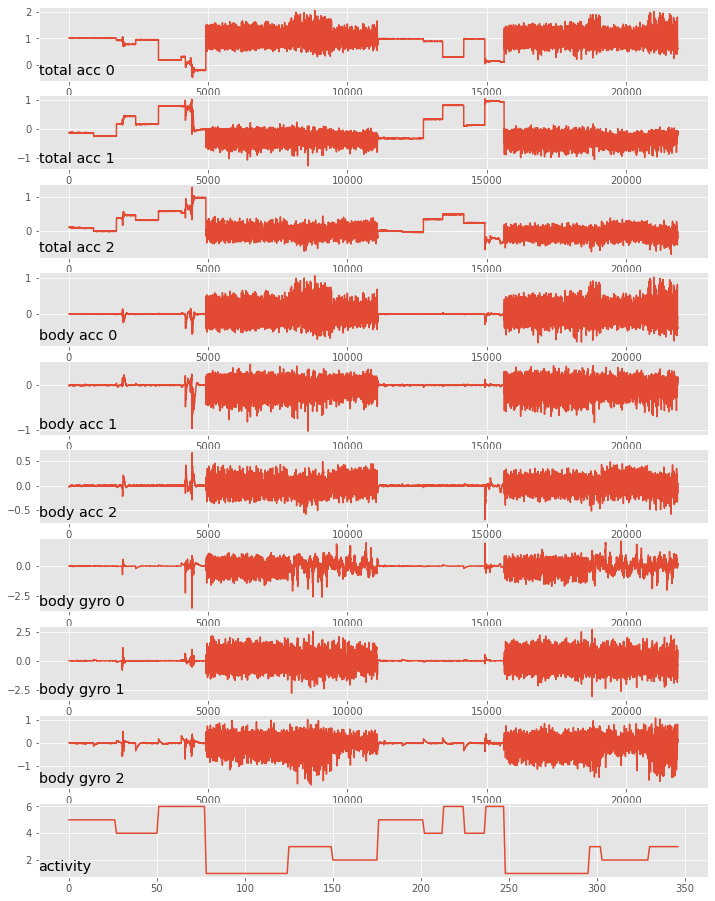

In [87]:
plot_subject(subX, suby)

- 1, 2, 3일때 variation이 크고, 정적일 때 적다.

In [88]:
sub_id = train_subjects[1]

In [89]:
sub_id

3

In [90]:
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)

(341, 128, 9) (341, 1)


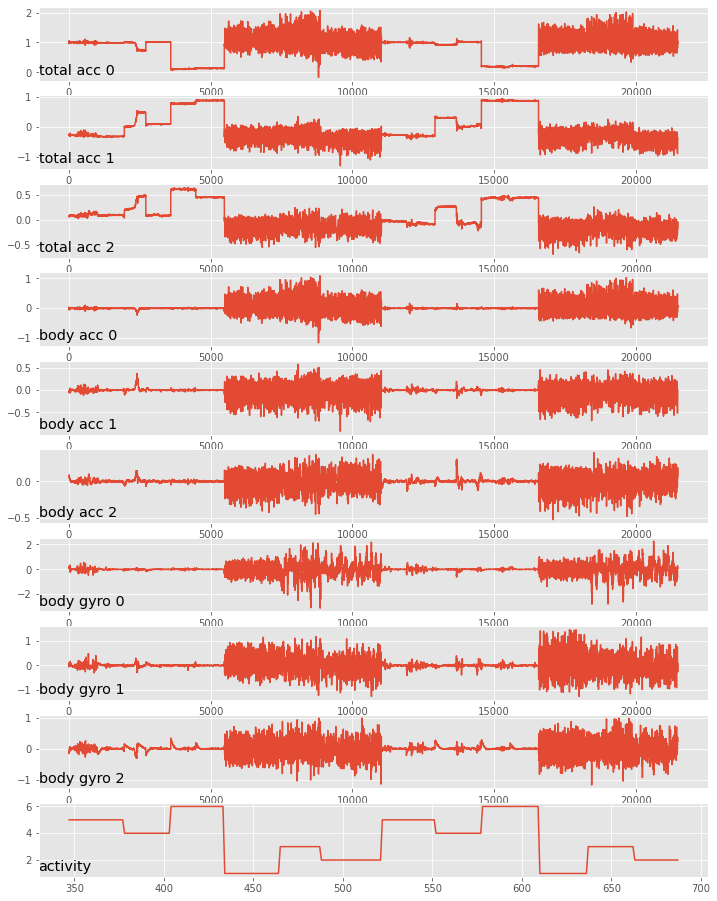

In [91]:
plot_subject(subX, suby)

### Plot Histograms Per Subject

데이터를 정규화 할 필요가 있다....???

In [101]:
def plot_subject_histograms(X, y, sub_map, n=10):
	plt.figure(figsize = (12, 16))
	# get unique subjects
	subject_ids = np.unique(sub_map.values)
	# enumerate subjects
	xaxis = None
	for k in range(n):
		sub_id = subject_ids[k]
		# get data for one subject
		subX, _ = data_for_subject(X, y, sub_map, sub_id)
		# total acc
		for i in range(3):
			ax = plt.subplot(n, 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			plt.hist(to_series(subX[:,:,i]), bins=100)
	plt.show()

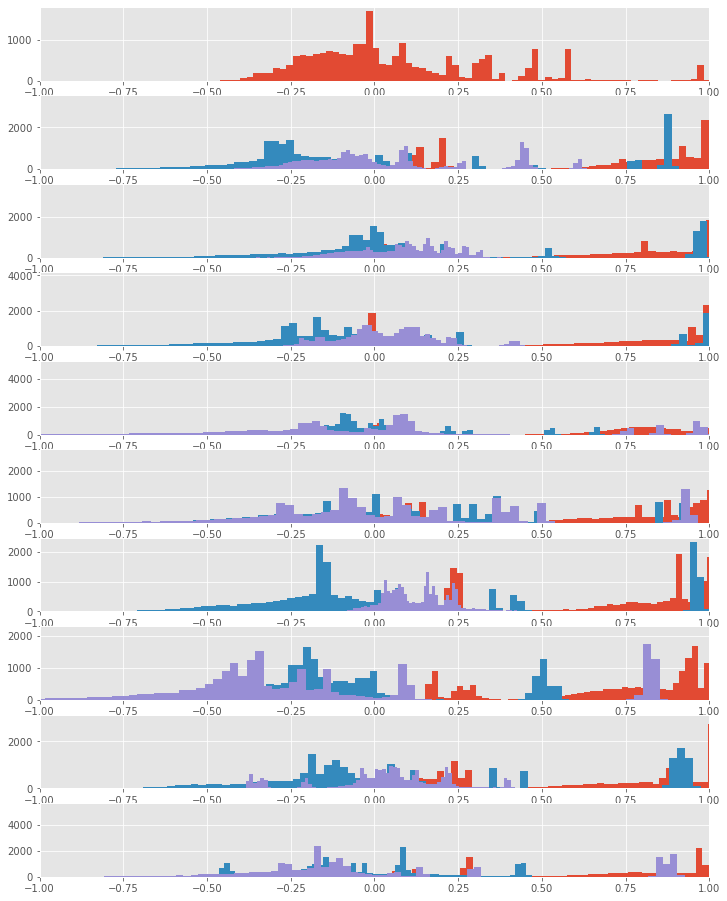

In [102]:
X, y = load_dataset('train', 'data/UCI HAR Dataset/')
# load mapping of rows to subjects
sub_map = load_file('data/UCI HAR Dataset/train/subject_train.txt')
# plot histograms for subjects
plot_subject_histograms(X, y, sub_map)

같은 방법으로 다른 body acceleration에 대한 분포도 그릴수 있다.

In [103]:
def plot_subject_histograms(X, y, sub_map, n=10):
	plt.figure(figsize = (12, 16))
	# get unique subjects
	subject_ids = np.unique(sub_map.values)
	# enumerate subjects
	xaxis = None
	for k in range(n):
		sub_id = subject_ids[k]
		# get data for one subject
		subX, _ = data_for_subject(X, y, sub_map, sub_id)
		# total acc
		for i in range(3):
			ax = plt.subplot(n, 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			plt.hist(to_series(subX[:,:,3+i]), bins=100)
	plt.show()

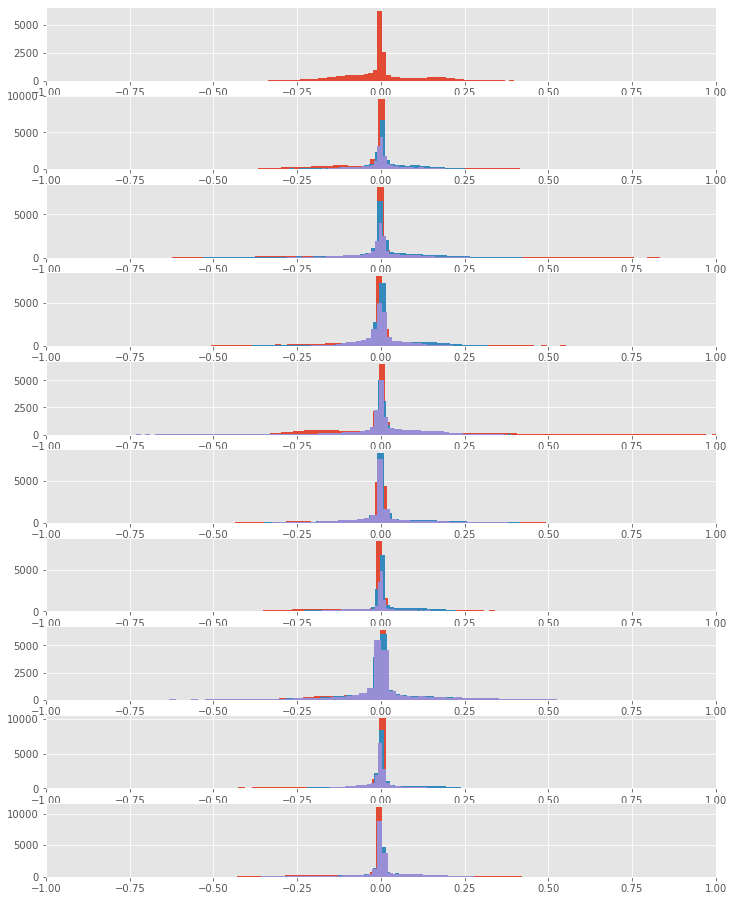

In [104]:
X, y = load_dataset('train', 'data/UCI HAR Dataset/')
# load mapping of rows to subjects
sub_map = load_file('data/UCI HAR Dataset/train/subject_train.txt')
# plot histograms for subjects
plot_subject_histograms(X, y, sub_map)

In [105]:
def plot_subject_histograms(X, y, sub_map, n=10):
	plt.figure(figsize = (12, 16))
	# get unique subjects
	subject_ids = np.unique(sub_map.values)
	# enumerate subjects
	xaxis = None
	for k in range(n):
		sub_id = subject_ids[k]
		# get data for one subject
		subX, _ = data_for_subject(X, y, sub_map, sub_id)
		# total acc
		for i in range(3):
			ax = plt.subplot(n, 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			plt.hist(to_series(subX[:,:,6+i]), bins=100)
	plt.show()

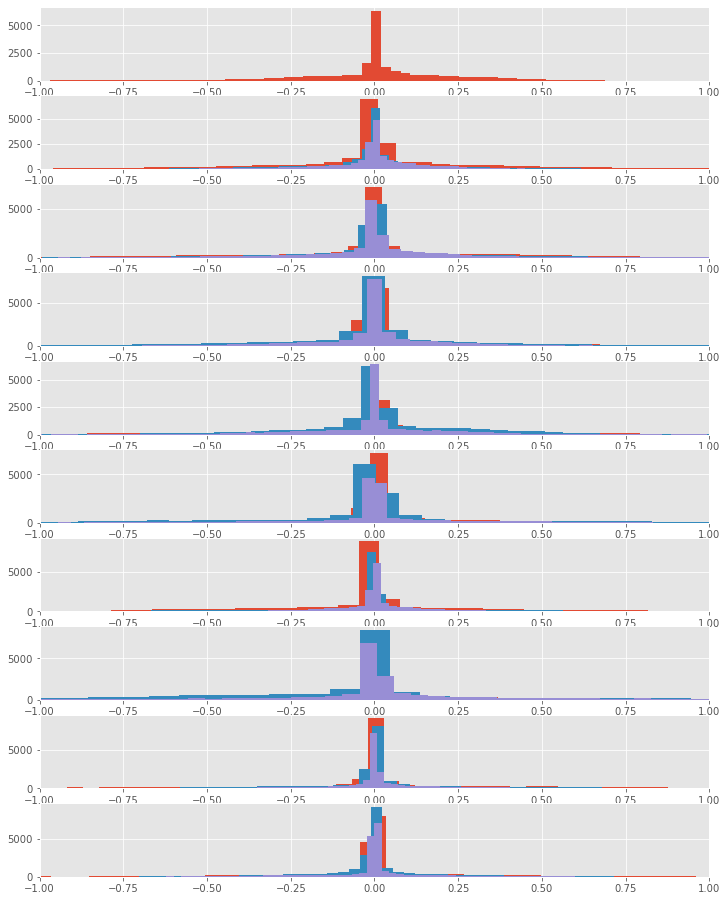

In [106]:
X, y = load_dataset('train', 'data/UCI HAR Dataset/')
# load mapping of rows to subjects
sub_map = load_file('data/UCI HAR Dataset/train/subject_train.txt')
# plot histograms for subjects
plot_subject_histograms(X, y, sub_map)

### Plot Histograms Per Activity

그런데 우리는 각 동작별 데이터의 차이를 보고 싶을 수도 있다.  
이를 위해 동작별 데이터를 분리하는 함수를 만든다.

In [154]:
def data_by_activity(X, y, activities):
	# group windows by activity
	return {a:X[y.iloc[:, 0]==a, :, :] for a in activities}

In [155]:
# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
	# get a list of unique activities for the subject
	activity_ids = np.unique(y.values)
	# group windows by activity
	grouped = data_by_activity(X, y, activity_ids)
	# plot per activity, histograms for each axis
	plt.figure(figsize = (16, 12))
	xaxis = None
	for k in range(len(activity_ids)):
		act_id = activity_ids[k]
		# total acceleration
		for i in range(3):
			ax = plt.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			plt.hist(to_series(grouped[act_id][:,:,i]), bins=100)
			plt.title('activity '+str(act_id), y=0, loc='left')
	plt.show()

In [156]:
trainX, trainy = load_dataset('train', 'data/UCI HAR Dataset/')
# load mapping of rows to subjects
sub_map = load_file('data/UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)

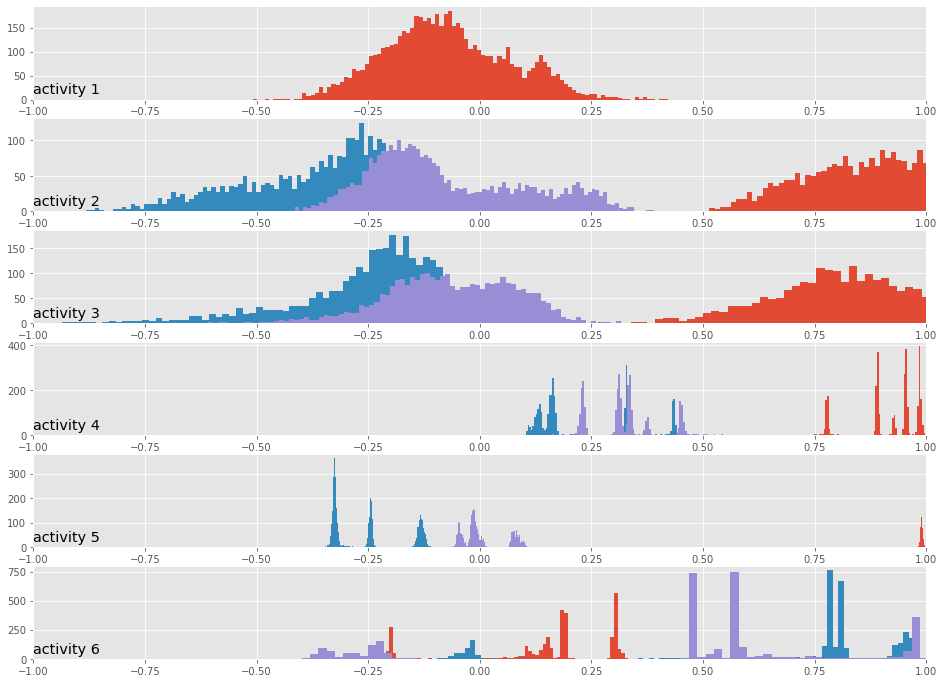

In [158]:
plot_activity_histograms(subX, suby)

수정해서 body acceleration에 대한 것도 그릴수 있다.

In [159]:
def plot_activity_histograms(X, y):
	# get a list of unique activities for the subject
	activity_ids = np.unique(y.values)
	# group windows by activity
	grouped = data_by_activity(X, y, activity_ids)
	# plot per activity, histograms for each axis
	plt.figure(figsize = (16, 12))
	xaxis = None
	for k in range(len(activity_ids)):
		act_id = activity_ids[k]
		# total acceleration
		for i in range(3):
			ax = plt.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			plt.hist(to_series(grouped[act_id][:,:,3+i]), bins=100)
			plt.title('activity '+str(act_id), y=0, loc='left')
	plt.show()

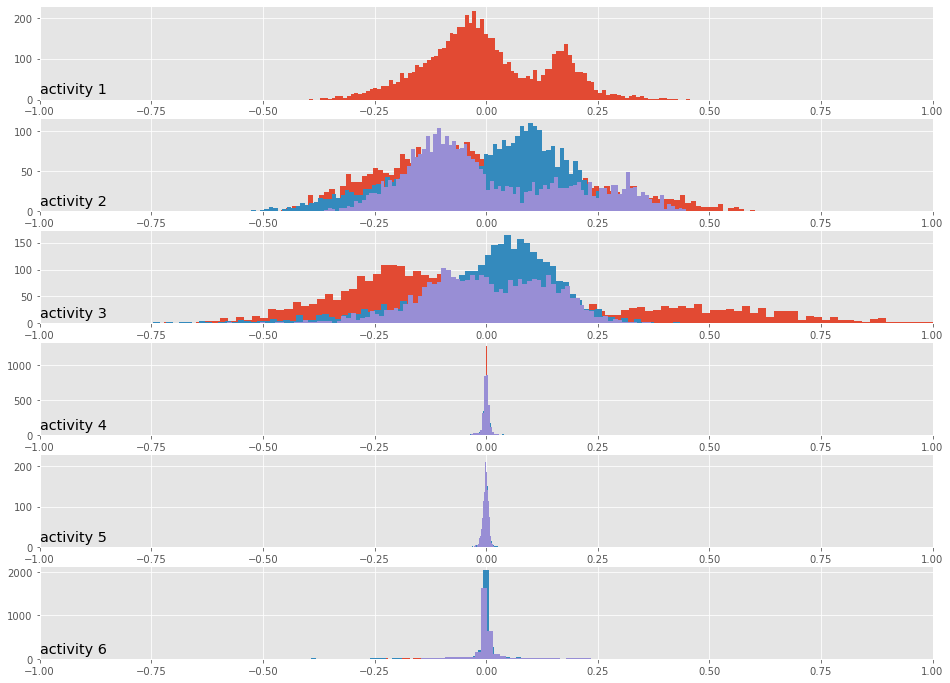

In [160]:
plot_activity_histograms(subX, suby)

마찬가지로 gyroscopic 데이터에 관한 것도 그릴 수 있다.

In [161]:
def plot_activity_histograms(X, y):
	# get a list of unique activities for the subject
	activity_ids = np.unique(y.values)
	# group windows by activity
	grouped = data_by_activity(X, y, activity_ids)
	# plot per activity, histograms for each axis
	plt.figure(figsize = (16, 12))
	xaxis = None
	for k in range(len(activity_ids)):
		act_id = activity_ids[k]
		# total acceleration
		for i in range(3):
			ax = plt.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			plt.hist(to_series(grouped[act_id][:,:,6+i]), bins=100)
			plt.title('activity '+str(act_id), y=0, loc='left')
	plt.show()

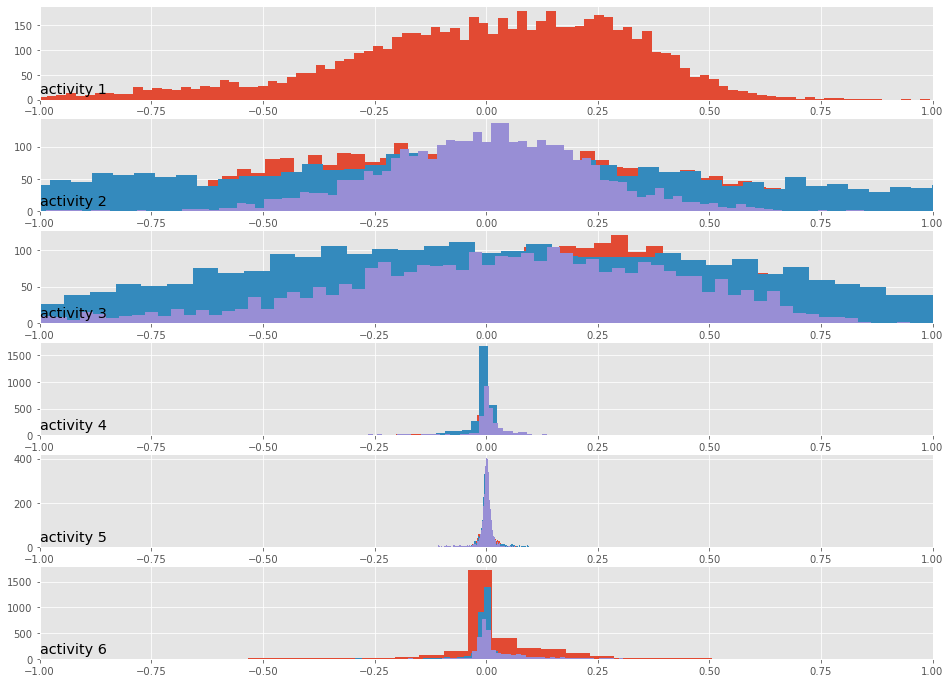

In [162]:
plot_activity_histograms(subX, suby)